# A Guide to Classification with Regression

We start by importing the Python libraries and our data set:

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
import sklearn as sl

In [7]:
CreditCard = pd.read_csv("creditcard_2023.csv")
CreditCard

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568625,568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,...,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.16,1
568626,568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,...,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.40,1
568627,568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,...,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85,1
568628,568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,...,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83,1


## Preprocessing

### Cleaning Data

In [8]:
if CreditCard.isna().sum().sum() > 1:
    CreditCard.dropna(inplace=True)  # drop rows containing invalid values
    print("Removed invalid data.")
else:
    print("No invalid data found.")

CreditCard.drop(columns=['id'], inplace=True)


No invalid data found.


Looking at the data set, we can make the following observations:

* The first column just contains an ascending id, so we removed this redundant column.
* No invalid entries are found, so no cleaning of rows was needed.
* Attributes V1 to V28 are anonymized to protect the privacy of customers in the data set.

We can also have a look at the scatter matrix of the first attributes:

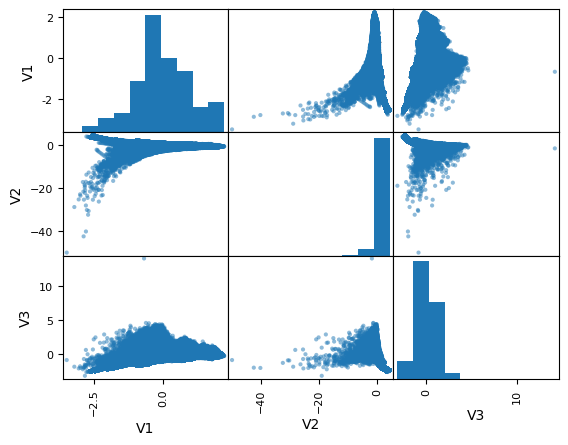

In [9]:
pd.plotting.scatter_matrix(CreditCard[['V1', 'V2', 'V3']]);

In [10]:
print("Fraudulent Transactions:", sum(CreditCard['Class'] == 1))
print("Normal Transactions:", sum(CreditCard['Class'] == 0))

Fraudulent Transactions: 284315
Normal Transactions: 284315


So the fraction of fraudulent transactions is exactly $0.5$, this is explained by the data set just being designed this way. This balanced distribution allows us to measure the model accuracy using standard methods. Credit card data sets which are not balanced often have a fraction of fraudulent activity $\leq 0.1 \%$. In those cases special accuracy definitions like "Area Under the Precision-Recall Curve" should be used, since the standard methods are not adequate.

## Collinearity Detection

Collinear parameters are defined by a very high correlation ($> 0.8$), meaning an effect can't be attributed to a single parameter. This leads to numeric instability in the regression calculation.

For detecting if a pair of parameters are collinear, we can just look if the correlation matrix contains entries $> 0.8$:

In [11]:
CreditCard.corr(numeric_only=True)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
V1,1.000000,-0.561184,0.484499,-0.498963,0.517462,0.354728,0.573381,-0.226757,0.548973,0.599108,...,-0.034669,-0.073729,-0.068917,-0.014651,-0.008508,0.009281,-0.122772,0.070111,-0.001280,-0.505761
V2,-0.561184,1.000000,-0.627810,0.579638,-0.631669,-0.341040,-0.694022,0.191321,-0.585095,-0.621798,...,-0.013570,0.035346,0.151906,-0.027515,0.132443,0.012219,0.053835,0.021071,-0.000076,0.491878
V3,0.484499,-0.627810,1.000000,-0.687726,0.510351,0.508974,0.634336,-0.263018,0.648615,0.707676,...,-0.021710,-0.041970,-0.058884,0.076460,-0.076332,-0.052056,-0.190582,0.005346,-0.002001,-0.682095
V4,-0.498963,0.579638,-0.687726,1.000000,-0.429243,-0.474403,-0.588648,0.199013,-0.676648,-0.712839,...,-0.013093,0.091197,0.043266,-0.102508,0.029402,0.136679,0.188036,-0.011316,0.001859,0.735981
V5,0.517462,-0.631669,0.510351,-0.429243,1.000000,0.245187,0.586828,-0.314975,0.479614,0.563874,...,0.034147,-0.119152,-0.113919,-0.083243,-0.047845,0.047771,-0.043759,0.108422,-0.000016,-0.338639
V6,0.354728,-0.341040,0.508974,-0.474403,0.245187,1.000000,0.418703,-0.604491,0.432241,0.471000,...,-0.040153,0.036896,0.308598,-0.005237,-0.195340,-0.067605,-0.260783,-0.065641,0.000734,-0.435088
V7,0.573381,-0.694022,0.634336,-0.588648,0.586828,0.418703,1.000000,-0.180986,0.601789,0.678004,...,0.019627,-0.104043,-0.111177,-0.004152,0.000802,-0.006488,-0.036557,0.040732,0.001326,-0.491234
V8,-0.226757,0.191321,-0.263018,0.199013,-0.314975,-0.604491,-0.180986,1.000000,-0.208557,-0.199995,...,0.056416,-0.098752,-0.463649,0.083272,0.322639,0.040448,0.298398,0.046017,-0.000208,0.144294
V9,0.548973,-0.585095,0.648615,-0.676648,0.479614,0.432241,0.601789,-0.208557,1.000000,0.748487,...,0.131001,-0.204723,-0.042371,0.044006,-0.034885,-0.131000,-0.111842,0.069959,-0.001589,-0.585522
V10,0.599108,-0.621798,0.707676,-0.712839,0.563874,0.471000,0.678004,-0.199995,0.748487,1.000000,...,0.037426,-0.150957,-0.056285,0.045935,-0.014045,-0.053684,-0.134907,0.035646,-0.001259,-0.673665


But often collinearity exists between three or more variables, so better practice is to check if the variance inflation factor (VIF) is bigger than a threshold, often choosen between $5$ and $10$.

In [23]:
import statsmodels as sm

X = sm.tools.tools.add_constant(CreditCard[CreditCard.columns.drop(['Class'])])  # regression matrix

vif = pd.Series([sm.stats.outliers_influence.variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
vif




const     4.028678
V1        2.105776
V2        3.034875
V3        3.022703
V4        3.067169
V5        2.894080
V6        2.506364
V7        3.055107
V8        2.722728
V9        2.970366
V10       3.953038
V11       3.376454
V12       4.039609
V13       1.153581
V14       3.912997
V15       1.165098
V16       4.891915
V17       6.536299
V18       4.035031
V19       2.014014
V20       1.790715
V21       3.575843
V22       2.733672
V23       1.579823
V24       1.133900
V25       1.382206
V26       1.112986
V27       1.560585
V28       1.275454
Amount    1.000059
dtype: float64

In [25]:
highVifColumns = vif[vif > 5].index
print(highVifColumns)

CreditCard.drop(columns=highVifColumns, inplace=True)

Index(['V17'], dtype='object')


We observe that V17 is the only collinear parameter, which we can then drop.